In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [ ]:
data_dir = "/content/drive/MyDrive/Art-GAN"

In [ ]:
stats = (.5, .5, .5), (.5, .5, .5)
transforms = T.Compose([
    T.Resize((128, 128)),
    T.CenterCrop(128),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)
])
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transforms)

In [ ]:
def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]

batch_size=128
train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


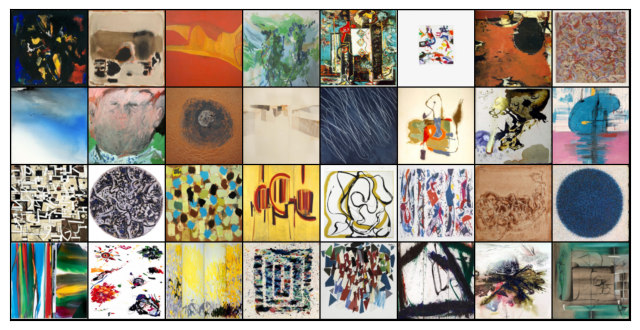

In [ ]:
def show_image(train_dl):
    for images,_ in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images.detach()[:32]), nrow=8).permute(1,2,0))
        break

show_image(train_dl)

In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_size):
    super(Generator, self).__init__()
    self.ls = latent_size
    self.convt2d1 = nn.ConvTranspose2d(self.ls, 1024, kernel_size=4, stride=1, padding=0, bias=False)
    self.convt2d2 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt2d3 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt2d4 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt2d5 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt2d6 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False)

    self.bn2d1 = nn.BatchNorm2d(64)
    self.bn2d2 = nn.BatchNorm2d(128)
    self.bn2d3 = nn.BatchNorm2d(256)
    self.bn2d4 = nn.BatchNorm2d(512)
    self.bn2d5 = nn.BatchNorm2d(1024)

    self.tanh = nn.Tanh()
    self.relu = nn.ReLU(True)

  def forward(self, x):

    x = self.relu(self.bn2d5(self.convt2d1(x)))
    x = self.relu(self.bn2d4(self.convt2d2(x)))
    x = self.relu(self.bn2d3(self.convt2d3(x)))
    x = self.relu(self.bn2d2(self.convt2d4(x)))
    x = self.relu(self.bn2d1(self.convt2d5(x)))
    x = self.tanh(self.convt2d6(x))
    return x


class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.conv2d1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv2d2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv2d3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv2d4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv2d5 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv2d6 = nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False)

    self.bn2d1 = nn.BatchNorm2d(64)
    self.bn2d2 = nn.BatchNorm2d(128)
    self.bn2d3 = nn.BatchNorm2d(256)
    self.bn2d4 = nn.BatchNorm2d(512)
    self.bn2d5 = nn.BatchNorm2d(1024)

    self.lrelu = nn.LeakyReLU(0.2, inplace=True)
    self.fl = nn.Flatten()
    self.sig = nn.Sigmoid()

  def forward(self, x):
    x = self.lrelu(self.bn2d1(self.conv2d1(x)))
    x = self.lrelu(self.bn2d2(self.conv2d2(x)))
    x = self.lrelu(self.bn2d3(self.conv2d3(x)))
    x = self.lrelu(self.bn2d4(self.conv2d4(x)))
    x = self.lrelu(self.bn2d5(self.conv2d5(x)))
    x = self.sig(self.fl(self.conv2d6(x)))

    return x

In [ ]:
epochs = 100
lr_d = 10e-5
lr_g = 10e-4
latent_size = 128


In [ ]:
generator = Generator(latent_size)
generator = to_device(generator, device)

discriminator = Discriminator()
discriminator = to_device(discriminator, device)

In [ ]:
optim_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
optim_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))

In [ ]:
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()[:32], nrow=8).permute(1,2,0))

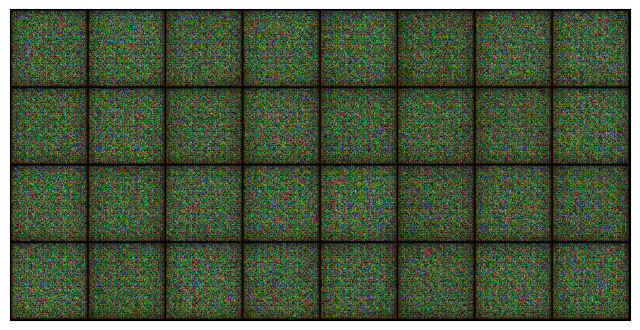

In [ ]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)

In [ ]:
def train(epochs, start_idx=1):
    torch.cuda.empty_cache()

    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
      for imgs, _ in tqdm(train_dl):
        optim_d.zero_grad()
        r_pred = discriminator(imgs)
        r_target = torch.ones(imgs.size(0), 1, device=device)
        r_loss = F.binary_cross_entropy(r_pred, r_target)
        r_score = torch.mean(r_pred).item()

        latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
        f_images = generator(latent)

        f_preds= discriminator(f_images)
        f_targets = torch.zeros(f_images.size(0), 1, device=device)
        f_loss = F.binary_cross_entropy(f_preds, f_targets)
        f_score = torch.mean(f_preds).item()

        loss = (r_loss + f_loss)/2
        loss.backward(),
        optim_d.step()
        loss_d = loss.item()
        losses_d.append(loss_d)
        real_scores.append(r_score)
        fake_scores.append(f_score)

        optim_g.zero_grad()

        latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
        f_images = generator(latent)

        preds = discriminator(f_images)
        targets = torch.ones(f_images.size(0), 1, device=device)
        g_loss = F.binary_cross_entropy(preds, targets)

        g_loss.backward()
        optim_g.step()
        loss_g = g_loss.item()
        losses_g.append(loss_g)

      print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_d, loss_g, r_score, f_score))
      save_sample(epoch+start_idx, fixed_latent, show=False)

In [ ]:
history = [train(epochs, start_idx=1)]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [1/100], loss_d: 0.6271, loss_g: 1.5130, real_score: 0.5459, fake_score: 0.4227


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [2/100], loss_d: 0.4741, loss_g: 2.1297, real_score: 0.5627, fake_score: 0.2303


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [3/100], loss_d: 0.6349, loss_g: 1.4012, real_score: 0.4582, fake_score: 0.3188


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [4/100], loss_d: 0.6745, loss_g: 1.7810, real_score: 0.6205, fake_score: 0.5450


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [5/100], loss_d: 0.5250, loss_g: 2.3505, real_score: 0.6808, fake_score: 0.4381


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [6/100], loss_d: 0.3414, loss_g: 1.8823, real_score: 0.6089, fake_score: 0.1469


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [7/100], loss_d: 0.7077, loss_g: 0.9318, real_score: 0.3911, fake_score: 0.2917


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [8/100], loss_d: 0.7732, loss_g: 1.4221, real_score: 0.5279, fake_score: 0.5301


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [9/100], loss_d: 0.3973, loss_g: 2.7369, real_score: 0.6764, fake_score: 0.3100


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [10/100], loss_d: 0.4432, loss_g: 1.6659, real_score: 0.5435, fake_score: 0.1945


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [11/100], loss_d: 0.6412, loss_g: 1.5221, real_score: 0.5634, fake_score: 0.4439


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [12/100], loss_d: 0.4375, loss_g: 1.7995, real_score: 0.6755, fake_score: 0.3502


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [13/100], loss_d: 0.4751, loss_g: 3.2416, real_score: 0.7521, fake_score: 0.4591


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [14/100], loss_d: 0.5169, loss_g: 3.1458, real_score: 0.7355, fake_score: 0.4806


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [15/100], loss_d: 0.5470, loss_g: 2.0046, real_score: 0.6792, fake_score: 0.4523


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [16/100], loss_d: 0.5421, loss_g: 1.7491, real_score: 0.5035, fake_score: 0.2610


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [17/100], loss_d: 0.6748, loss_g: 1.6791, real_score: 0.5718, fake_score: 0.4772


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [18/100], loss_d: 0.5054, loss_g: 1.9482, real_score: 0.5755, fake_score: 0.3056


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [19/100], loss_d: 0.5321, loss_g: 2.3104, real_score: 0.7053, fake_score: 0.4773


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [20/100], loss_d: 0.5199, loss_g: 2.6069, real_score: 0.6320, fake_score: 0.3665


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [21/100], loss_d: 0.7310, loss_g: 2.0570, real_score: 0.8148, fake_score: 0.6853


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [22/100], loss_d: 0.4285, loss_g: 1.1849, real_score: 0.5817, fake_score: 0.2291


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [23/100], loss_d: 0.5154, loss_g: 1.4328, real_score: 0.6430, fake_score: 0.4109


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [24/100], loss_d: 0.5503, loss_g: 1.5732, real_score: 0.4864, fake_score: 0.2547


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [25/100], loss_d: 0.5584, loss_g: 1.9656, real_score: 0.7085, fake_score: 0.4967


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [26/100], loss_d: 0.6690, loss_g: 1.1926, real_score: 0.4485, fake_score: 0.3378


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [27/100], loss_d: 0.5794, loss_g: 1.6510, real_score: 0.5230, fake_score: 0.3034


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [28/100], loss_d: 0.4924, loss_g: 1.9170, real_score: 0.5484, fake_score: 0.2589


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [29/100], loss_d: 0.3216, loss_g: 2.2144, real_score: 0.7906, fake_score: 0.3084


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [30/100], loss_d: 0.4431, loss_g: 2.8140, real_score: 0.6967, fake_score: 0.3588


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [31/100], loss_d: 0.4749, loss_g: 2.4874, real_score: 0.5746, fake_score: 0.2819


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [32/100], loss_d: 0.4372, loss_g: 1.8151, real_score: 0.5840, fake_score: 0.2232


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [33/100], loss_d: 0.5877, loss_g: 0.8038, real_score: 0.4250, fake_score: 0.1427


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [34/100], loss_d: 0.5830, loss_g: 1.7445, real_score: 0.4425, fake_score: 0.2179


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [35/100], loss_d: 0.5648, loss_g: 1.7210, real_score: 0.4758, fake_score: 0.2112


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [36/100], loss_d: 0.3581, loss_g: 3.2577, real_score: 0.7098, fake_score: 0.2780


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [37/100], loss_d: 0.4774, loss_g: 3.8603, real_score: 0.8721, fake_score: 0.5253


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [38/100], loss_d: 0.6108, loss_g: 3.8174, real_score: 0.8342, fake_score: 0.6089


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [39/100], loss_d: 0.2749, loss_g: 2.1115, real_score: 0.7265, fake_score: 0.1750


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [40/100], loss_d: 0.3980, loss_g: 2.4350, real_score: 0.6885, fake_score: 0.3091


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [41/100], loss_d: 1.3447, loss_g: 1.2402, real_score: 0.0895, fake_score: 0.0135


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [42/100], loss_d: 0.4418, loss_g: 3.5159, real_score: 0.7769, fake_score: 0.4349


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [43/100], loss_d: 0.5439, loss_g: 0.9521, real_score: 0.4420, fake_score: 0.1106


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [44/100], loss_d: 0.4869, loss_g: 2.1952, real_score: 0.5258, fake_score: 0.2193


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [45/100], loss_d: 0.6606, loss_g: 1.6531, real_score: 0.3256, fake_score: 0.0527


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [46/100], loss_d: 0.4062, loss_g: 2.0690, real_score: 0.5620, fake_score: 0.1719


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [47/100], loss_d: 0.6802, loss_g: 1.0885, real_score: 0.3122, fake_score: 0.0801


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [48/100], loss_d: 0.2647, loss_g: 3.0052, real_score: 0.9056, fake_score: 0.3297


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [49/100], loss_d: 0.9100, loss_g: 5.5834, real_score: 0.8357, fake_score: 0.7671


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [50/100], loss_d: 0.5203, loss_g: 3.1505, real_score: 0.8218, fake_score: 0.5286


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [51/100], loss_d: 0.4898, loss_g: 3.5785, real_score: 0.8120, fake_score: 0.5043


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [52/100], loss_d: 0.3783, loss_g: 2.5670, real_score: 0.5893, fake_score: 0.1647


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [53/100], loss_d: 0.4668, loss_g: 2.9766, real_score: 0.8518, fake_score: 0.5015


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [54/100], loss_d: 0.4637, loss_g: 1.5256, real_score: 0.5403, fake_score: 0.2164


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [55/100], loss_d: 0.3838, loss_g: 2.4983, real_score: 0.7119, fake_score: 0.3125


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [56/100], loss_d: 0.7044, loss_g: 2.6334, real_score: 0.7865, fake_score: 0.6513


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [57/100], loss_d: 0.2990, loss_g: 2.8110, real_score: 0.8034, fake_score: 0.2934


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [58/100], loss_d: 0.3976, loss_g: 3.9789, real_score: 0.7509, fake_score: 0.3564


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [59/100], loss_d: 0.3945, loss_g: 2.8280, real_score: 0.6691, fake_score: 0.2872


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [60/100], loss_d: 0.3319, loss_g: 2.4640, real_score: 0.7012, fake_score: 0.2347


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [61/100], loss_d: 0.5726, loss_g: 4.6510, real_score: 0.7773, fake_score: 0.5298


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [62/100], loss_d: 0.6407, loss_g: 0.8187, real_score: 0.3788, fake_score: 0.1210


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [63/100], loss_d: 0.5145, loss_g: 3.3532, real_score: 0.6075, fake_score: 0.3667


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [64/100], loss_d: 0.4427, loss_g: 2.3862, real_score: 0.5389, fake_score: 0.1807


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [65/100], loss_d: 0.3351, loss_g: 2.6474, real_score: 0.7586, fake_score: 0.2920


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [66/100], loss_d: 0.3020, loss_g: 3.4175, real_score: 0.6345, fake_score: 0.0991


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [67/100], loss_d: 0.4324, loss_g: 2.2887, real_score: 0.8013, fake_score: 0.4251


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [68/100], loss_d: 0.5221, loss_g: 3.7506, real_score: 0.7070, fake_score: 0.4329


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [69/100], loss_d: 0.2178, loss_g: 4.0027, real_score: 0.8249, fake_score: 0.2002


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [70/100], loss_d: 0.3974, loss_g: 3.8994, real_score: 0.8112, fake_score: 0.4096


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [71/100], loss_d: 0.4852, loss_g: 1.5190, real_score: 0.4514, fake_score: 0.0836


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [72/100], loss_d: 0.4872, loss_g: 3.0153, real_score: 0.7891, fake_score: 0.4707


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [73/100], loss_d: 0.5674, loss_g: 2.9696, real_score: 0.5750, fake_score: 0.3722


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [74/100], loss_d: 0.4087, loss_g: 2.9968, real_score: 0.6716, fake_score: 0.3011


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [75/100], loss_d: 0.4229, loss_g: 4.0365, real_score: 0.8396, fake_score: 0.4598


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [76/100], loss_d: 0.3928, loss_g: 2.6866, real_score: 0.7759, fake_score: 0.3822


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [77/100], loss_d: 0.3465, loss_g: 2.7754, real_score: 0.7689, fake_score: 0.3045


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [78/100], loss_d: 0.3798, loss_g: 3.1189, real_score: 0.7396, fake_score: 0.3214


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [79/100], loss_d: 0.5790, loss_g: 3.6818, real_score: 0.6939, fake_score: 0.5143


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [80/100], loss_d: 0.3642, loss_g: 1.9146, real_score: 0.6546, fake_score: 0.2288


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [81/100], loss_d: 0.5472, loss_g: 1.8920, real_score: 0.4572, fake_score: 0.1516


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [82/100], loss_d: 0.4766, loss_g: 2.3919, real_score: 0.6265, fake_score: 0.3230


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [83/100], loss_d: 0.3768, loss_g: 2.1495, real_score: 0.6158, fake_score: 0.1950


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [84/100], loss_d: 0.5547, loss_g: 1.6356, real_score: 0.4800, fake_score: 0.2119


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [85/100], loss_d: 0.5343, loss_g: 3.4571, real_score: 0.7218, fake_score: 0.4722


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [86/100], loss_d: 0.6711, loss_g: 1.2924, real_score: 0.3351, fake_score: 0.0527


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [87/100], loss_d: 0.3695, loss_g: 4.4409, real_score: 0.7821, fake_score: 0.3605


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [88/100], loss_d: 0.5888, loss_g: 1.9104, real_score: 0.5020, fake_score: 0.3309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [89/100], loss_d: 0.3309, loss_g: 4.0573, real_score: 0.7770, fake_score: 0.3115


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [90/100], loss_d: 0.4666, loss_g: 3.4449, real_score: 0.7703, fake_score: 0.4467


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [91/100], loss_d: 0.4421, loss_g: 2.8921, real_score: 0.7167, fake_score: 0.3882


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [92/100], loss_d: 0.5373, loss_g: 2.4679, real_score: 0.6184, fake_score: 0.3809


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [93/100], loss_d: 0.4420, loss_g: 2.4898, real_score: 0.7405, fake_score: 0.4028


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [94/100], loss_d: 0.4719, loss_g: 3.3092, real_score: 0.6481, fake_score: 0.3584


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [95/100], loss_d: 0.4235, loss_g: 2.3392, real_score: 0.6483, fake_score: 0.2962


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [96/100], loss_d: 0.5844, loss_g: 1.8667, real_score: 0.5203, fake_score: 0.3331


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [97/100], loss_d: 0.4356, loss_g: 2.5254, real_score: 0.6133, fake_score: 0.2604


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [98/100], loss_d: 0.4343, loss_g: 2.5407, real_score: 0.8063, fake_score: 0.4264


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [99/100], loss_d: 0.4446, loss_g: 2.4703, real_score: 0.7015, fake_score: 0.3680


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [100/100], loss_d: 0.3822, loss_g: 2.2694, real_score: 0.6379, fake_score: 0.2274


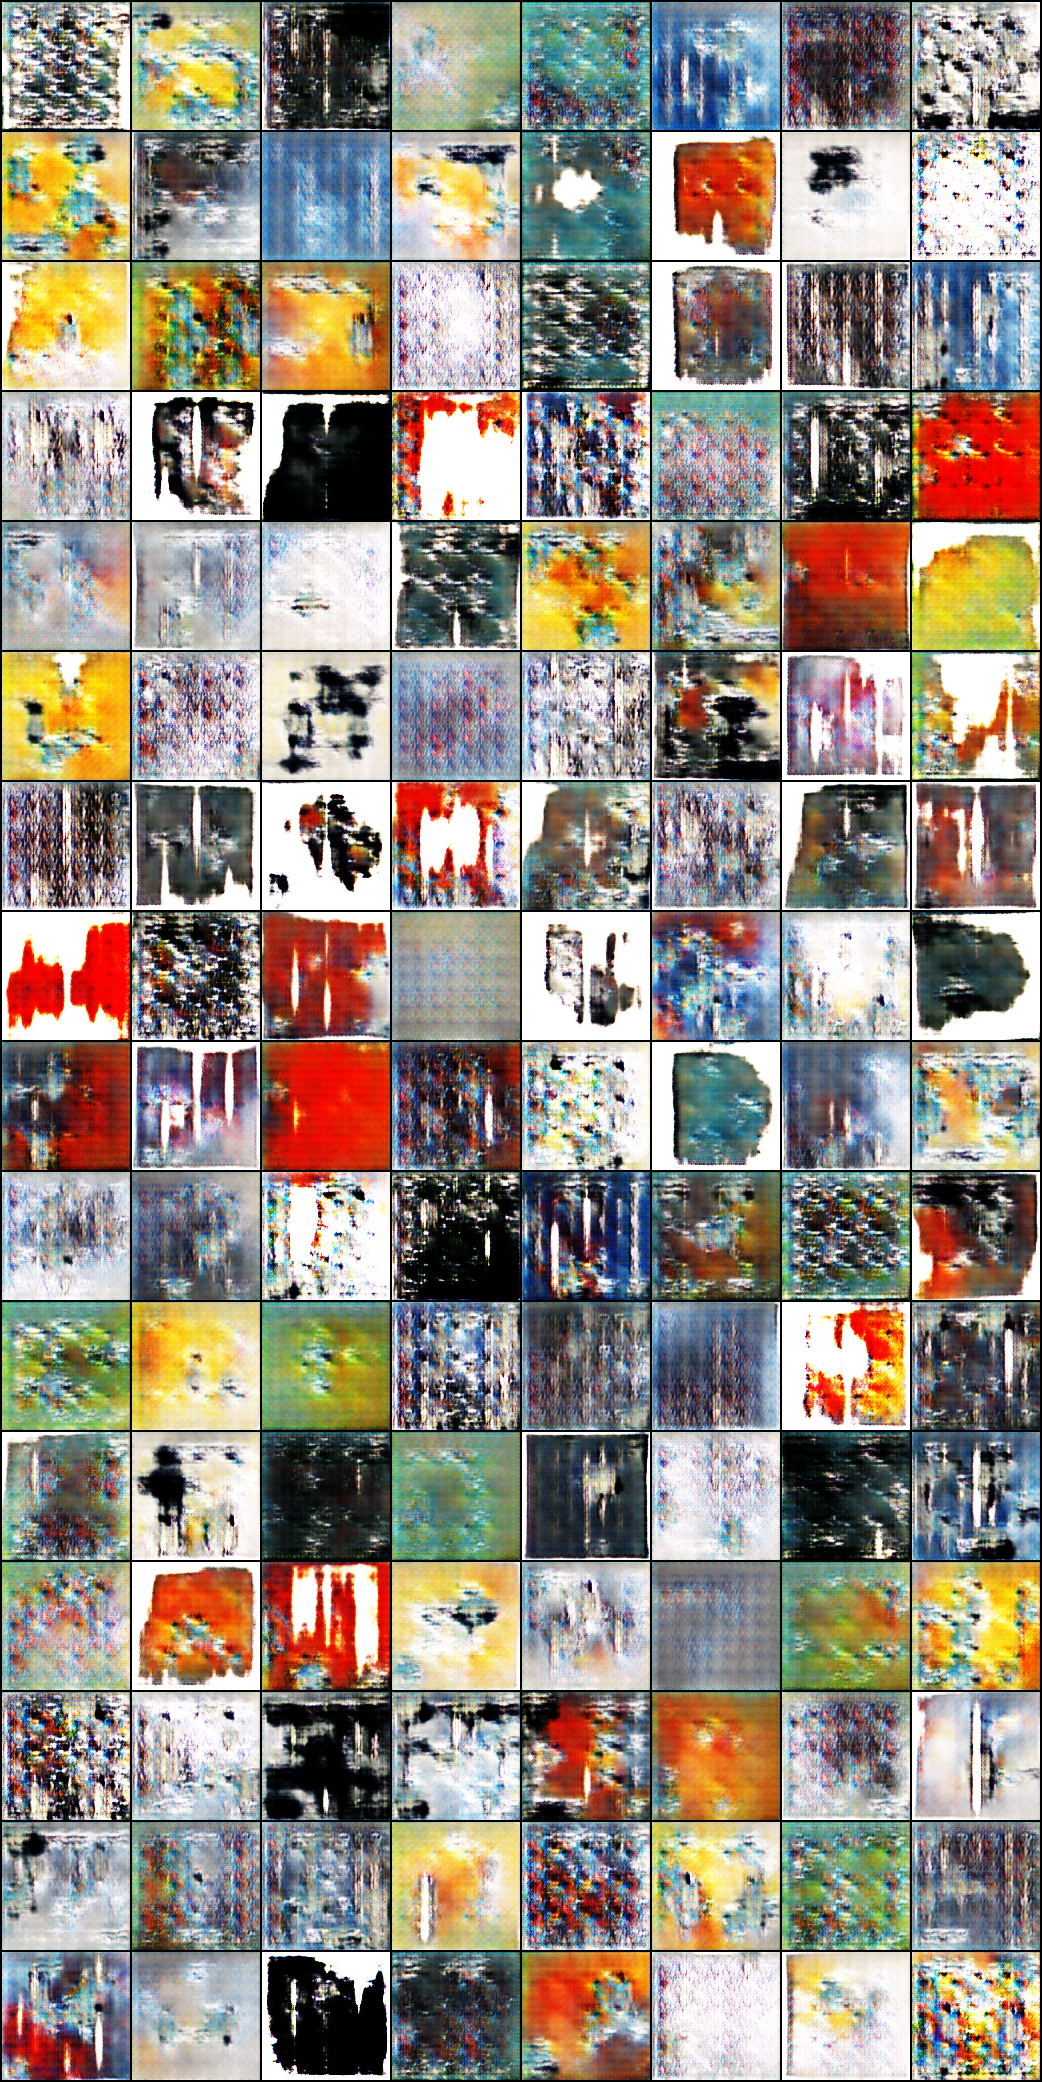

In [ ]:
Image("/content/generated/generated-images-0100.png")

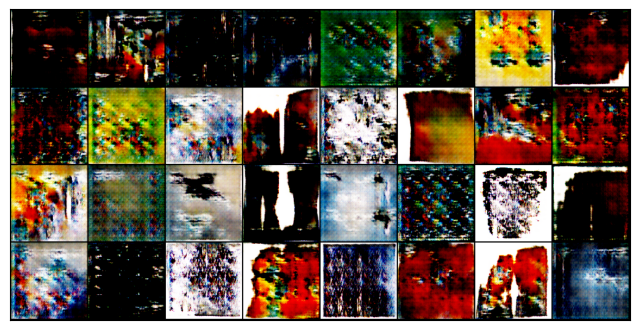

In [ ]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)

In [ ]:
test_dir = "/content/drive/MyDrive/Art-GAN/Abstract_gallery_2"


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
testset = TestDataset(test_dir, transforms)

In [ ]:
batch_size=128
test_dl = DataLoader(testset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def test(test_dataloader):
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        real_score_sum, fake_score_sum = 0.0, 0.0
        for real_images in test_dataloader:
            real_images = real_images.to(device)
            real_preds = discriminator(real_images)
            real_score_sum += torch.mean(real_preds).item()

            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            fake_preds = discriminator(fake_images)
            fake_score_sum += torch.mean(fake_preds).item()

        avg_real_score = real_score_sum / len(test_dataloader)
        avg_fake_score = fake_score_sum / len(test_dataloader)

    print(f"Average Real Score: {avg_real_score:.4f}, Average Fake Score: {avg_fake_score:.4f}")
    generator.train()
    discriminator.train()




In [ ]:
test(test_dl)

Average Real Score: 0.5382, Average Fake Score: 0.2889
